# BMENE4480 Final 
## Authors (* indicates all authors contributed equally): 
@lauren friend:* friend.lauren@columbia.edu
@ Joy Fan * 
@Cameron Park * 

In [1]:
# load modules
import os
import sys
import gzip
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
import bhtsne
import anndata
import scanpy
import scipy
import phenograph # install from https://github.com/jacoblevine/PhenoGraph
import collections
from scipy.io import mmread,mminfo

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def graph_patients(df_list, names_list, xrange=None):
    fig = plt.figure(figsize=[4 * len(df_list), 4])
    for i, sample in enumerate(df_list):
        ms = np.log10(sample.sum(axis=1)) #library size
        # Figure
        ax = fig.add_subplot(1, len(df_list), i+1)
        ax.hist(ms,50,xrange)
        ax.set_title(names_list[i])
        ax.set_xlabel('log10 of library size')

In [3]:
def cell_filter(threshold, sample):
    ms = sample.sum(axis = 1) #library size 
    use_cells = ms.index[np.log10(ms) > threshold]
    sample = sample.loc[use_cells]
    print(sample.shape)
    return sample

In [4]:
def gene_filter(sample,threshold=0):
    before = sample.shape[1]
    use_genes = sample.columns[sample.sum(axis=0) > threshold]
    sample = sample[use_genes]
    print(before - sample.shape[1] , "genes removed")
    return sample

# Loading in Patient 2's files 

In [5]:
path="/Users/lauren_friend/Desktop/AziziLab/visium"

#patient 2A
patient_2A_path = f"{path}/Patient2A_021120_IGO_10778_3/outs"
patient_2A_filtered_path = f"{patient_2A_path}/filtered_feature_bc_matrix"
#patient 2B
patient_2B_path = f"{path}/Patient2B_021120_IGO_10778_4/outs"
patient_2B_filtered_path = f"{patient_2B_path}/filtered_feature_bc_matrix"

### 2A

In [6]:
%%time
with gzip.open(f"{patient_2A_filtered_path}/barcodes.tsv.gz",mode="rb") as f:
    barcodes_2A = pd.read_csv(f, sep='\t', names=['barcode'])
with gzip.open(f"{patient_2A_filtered_path}/features.tsv.gz",mode="rb") as f:
    features_2A = pd.read_csv(f, sep='\t',names=['geneID','gene_name','type'])
with gzip.open(f"{patient_2A_filtered_path}/matrix.mtx.gz",mode="rb") as f:
    matrix_2A = mmread(f)

CPU times: user 25.2 s, sys: 98.9 ms, total: 25.3 s
Wall time: 25.4 s


In [7]:
print(features_2A.shape)
print(barcodes_2A.shape)
print(matrix_2A.shape)

(36601, 3)
(3245, 1)
(36601, 3245)


In [8]:
#transposing matrix to cellsxgenes
matrix_2A_transpose = matrix_2A.transpose()
#creating anndata object 
ad_2A = anndata.AnnData(X=matrix_2A_transpose,obs=barcodes_2A,var=features_2A)
#creating dataframe
matrix_2A_transpose_dense=matrix_2A_transpose.todense()
df_2A = pd.DataFrame(matrix_2A_transpose_dense,columns=[x for x in features_2A['gene_name']])
barcodes_df_2A=barcodes_2A.join(df_2A)
df_2A.index = [f'A_{i}' for i in df_2A.index]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### 2B

In [9]:
with gzip.open(f"{patient_2B_filtered_path}/barcodes.tsv.gz",mode="rb") as f:
    barcodes_2B = pd.read_csv(f, sep='\t', names=['barcode'])
with gzip.open(f"{patient_2B_filtered_path}/features.tsv.gz",mode="rb") as f:
    features_2B = pd.read_csv(f, sep='\t',names=['geneID','gene_name','type'])
with gzip.open(f"{patient_2B_filtered_path}/matrix.mtx.gz",mode="rb") as f:
    matrix_2B = mmread(f)

In [10]:
print(features_2B.shape)
print(barcodes_2B.shape)
print(matrix_2B.shape)

(36601, 3)
(3201, 1)
(36601, 3201)


In [11]:
#transposing matrix to cellsxgenes
matrix_2B_transpose = matrix_2B.transpose()
#creating anndata object 
ad_2B = anndata.AnnData(X=matrix_2B_transpose,obs=barcodes_2B,var=features_2B)
#creating dataframe
matrix_2B_transpose_dense=matrix_2B_transpose.todense()
df_2B = pd.DataFrame(matrix_2B_transpose_dense,columns=[x for x in features_2B['gene_name']])
barcodes_df_2B=barcodes_2B.join(df_2B)
df_2B.index = [f'B_{i}' for i in df_2B.index]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Patient 2, combined data

In [12]:
df2 = pd.concat([df_2A,df_2B])

# Filtering 

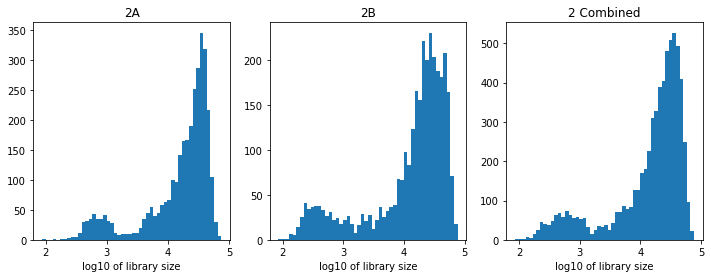

In [13]:
names = ['2A','2B','2 Combined']
dataframes = [df_2A,df_2B, df2]

graph_patients(dataframes,names)

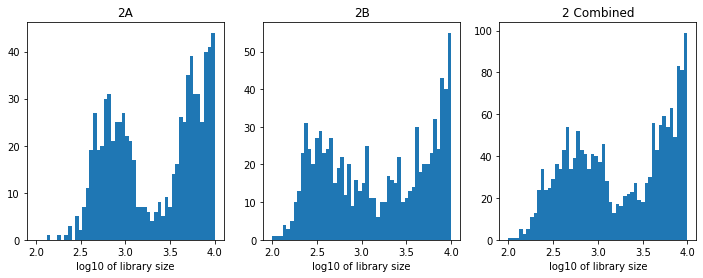

In [14]:
graph_patients(dataframes,names,(2,4))

In [13]:
df2 = cell_filter(2,df2)

(6444, 36601)


In [14]:
df2 = gene_filter(df2,5)

14911 genes removed


## Normalize

In [15]:
ms = df2.sum(axis=1) #library size
norm_df = df2.div(ms, axis=0).mul(np.median(ms), axis=0)
log_norm_df = np.log(0.1+ norm_df)

## PCA

In [18]:
from sklearn.decomposition import PCA
# PCA
no_eigs = 100
pca = PCA(n_components=no_eigs)
pca.fit(log_norm_df.values)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

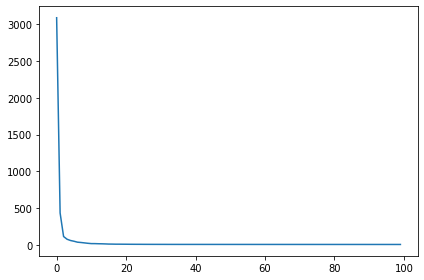

In [19]:
# Get Eiganvectors
eig_vectors = pca.components_
# Get Eiganvalues
eig_values = pca.explained_variance_
plt.plot(eig_values)
plt.tight_layout()

In [ ]:
pca= PCA(n_components=10)
pca_projections = pd.DataFrame(pca.fit_transform(log_norm_df),
                index=log_norm_df.index)

# Visualize

In [ ]:
import umap
def perform_umap(pca_dataframe,neighbors=15): #15-50 neighbors
    reducer = umap.UMAP(n_neighbors=neighbors)
    embedding = reducer.fit_transform(pca_dataframe)
    return embedding

def graph_umap(raw_df,norm_df,umap_output,title):
    ms=raw_df.sum(axis=1)
    plt.figure(figsize=[5, 3.5])
    plt.scatter(umap_output[:, 0],umap_output[:, 1],s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    plt.title(f'{title} UMAP colored by log 10 of expression')
    plt.colorbar()

In [ ]:
def perform_tsne(num_PC,pca_projections, perplexity, log_df):
    use_eigs = list(range(1, num_PC))
    data = pca_projections.values[:, use_eigs] 
    # tsNE
    tsne = pd.DataFrame(bhtsne.tsne(data, perplexity=perplexity), 
                index=log_df.index, columns=['x', 'y'])
    return tsne

def graph_tsne(raw_df,norm_df,tsne,title):
    ms = raw_df.sum(axis=1)
    plt.figure(figsize=[5, 3.5])
    plt.scatter(tsne['x'], tsne['y'], s=5, edgecolors='none',
        cmap=matplotlib.cm.Spectral_r, c=np.log10(ms[norm_df.index]))
    plt.title(f'{title} tSNE colored by log 10 of expression')
    plt.colorbar()

In [ ]:
umap_pca = perform_umap(pca_projections,15)

In [ ]:
umap = perform_umap(log_norm_df,15)

In [ ]:
tsne_pca = pd.DataFrame(bhtsne.tsne(pca_projections, perplexity=15), 
                index=log_norm_df.index, columns=['x', 'y'])

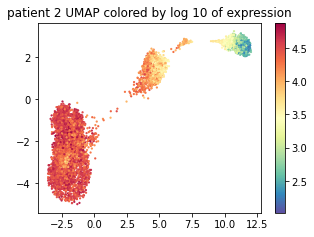

In [26]:
graph_umap(df2,norm_df,umap,'patient 2')

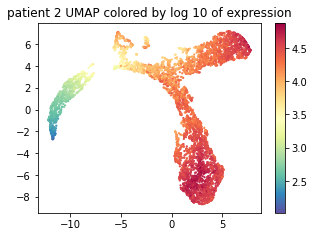

In [27]:
graph_umap(df2,norm_df,umap_pca,'patient 2')

CPU times: user 126 ms, sys: 1.08 ms, total: 127 ms
Wall time: 126 ms


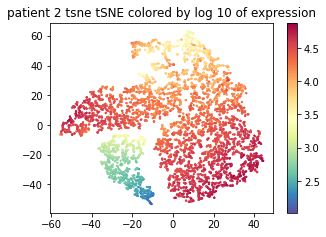

In [29]:
graph_tsne(df2,log_norm_df,tsne_pca,'patient 2 tsne')

# Fitting the vanilla GMM

In [16]:
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

In [17]:
import itertools
from scipy import linalg

In [18]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [19]:
print(log_norm_df.shape)
log_norm_df.head()

(6444, 21690)


,AL627309.1,AL627309.5,AP006222.2,AL732372.1,AC114498.1,AL669831.2,LINC01409,LINC01128,LINC00115,FAM41C,...,MT-ND6,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC007325.4
A_0,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,3.976320,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
A_1,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.472997,-2.302585,...,-2.302585,3.761126,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
A_2,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,2.384218,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
A_3,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,3.978092,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585
A_4,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,3.868561,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [20]:
import pickle 

In [25]:
%%time 
gmm = GaussianMixture(n_components=5).fit(log_norm_df)

pickle.dump(gmm, open( f"{path}/gmm.p", "wb" ) )

CPU times: user 2h 53min, sys: 5min 50s, total: 2h 58min 50s
Wall time: 39min 36s


In [ ]:
%%time
bayes_gmm = BayesianGaussianMixture(n_components=10, covariance_type='full').fit(log_norm_df)

pickle.dump(bayes_gmm, open( f"{path}/bayes_gmm.p", "wb" ) )

In [3]:
# import pickle 
# gmm = pickle.load( open( f"{path}/gmm.p", "rb" ) )